# Implementierung einer logistische Regression zur Erkennung von Werkzeugerkennung am Arbeitsplatz
Das Notebook beschreibt die Implementierung einer logistischen Regression für das klassifizieren von Bildern. Genauer gesagt, wollen wir herausfinden ob sich in einem Bild – beziehungsweise einem Kamerastream – ein Hammer befindet oder nicht. 


## Aufbau:
Der Beispielcode ist wie folgt aufgebaut: 
### Abschnitt 1: Datensatz vorbereiten
In diesem Abschnitt werden die notwendigen [Bibliotheken](./requirements.txt) eingebunden sowie die Daten aufbereitet. Es wird ein sogenanntes [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) erstellt welches die Bilder des Datensatzes verwaltet. Ebenso werden die Bilder in diesem Abschnitt von einer Matrix in einen Vektor umgewandelt. Die Theorie dazu ist in dem logistische Regression [Storyboard](11_Storyboard_logistic_regression.pdf) beschrieben.  

### Abschnitt 2: Erstellen des Modells
In Abschnitt 2 wird die logistische Regression definiert.  

Zum Einsatz kommt hier die [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) Bibliothek welche ermöglicht ein bereits existierendes Model einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. Was eine PCA ist und welche Parameter sich auf die LR auswirken sind ebenfalls im [Storyboard](11_Storyboard_logistic_regression.pdf) zu finden. 

### Abschnitt 3: Webcam Implementierung
In diesem Abschnitt wird die Webcam eingebunden mittels [OpenCV](https://opencv.org/). Da ein Video-Stream nur aus vielen hintereinader ablaufenden Bildern besteht, wird einfach jeder Frame (jedes Bild) angeschaut und Klassifiziert. Das Ergebnis wird direkt in das Bild hinein geschrieben und angezeigt. 


## Ordnerstruktur: 
1. demo [Ordner]
    - webcam_demo.gif
    - _demo images_
2. Tool_Data [Ordner]
(Hier kann der Datensatz geändert werden)
    - Hammer _data images_
    - Workspace _data images_
    
3. `image_augmentation.ipynb`
(Kann zur Image Augmentation verwendet werden. Muss an den verwendeten Datensatz angepasst werden bevor es ausgeführt wird)

4. `miniUsecases11_logistic_regression.ipynb` [Beispielcode]

5. `workspace_detection_{width}x{height}px.pkl`

6. `requirements.txt`
(Notwendige Bibliotheken, kann zum Installieren verwednet werden)

7. `11_Storyboard_logistic_regression.pdf`

8. `miniUsecases11_logistic_regression.ipynb` [Zusätzliche Funktionen und Visualisierungen]

## Resultat: 
![Abbildung 1](demo/webcam_demo.gif)




# Abschnitt 1: Datensatz vorbereiten

## Importieren der generellen notwendigen Bibliotheken
Wir empfehlen die notwendigen Bibliotheken über die [requirements.txt](requirements.txt) Datei zu installieren. Das ermöglicht es, dass automatisch die richtigen Versionen installiert werden. Sollte eine Library nicht vorhanden sein, dann kann die häufig auch mit `pip3 <package-name\>` nachinstalliert werden. Sind alle libraries vorhanden, entsteht kein Output bei der nächsten Zelle. 
Im laufe des Notebooks werden weitere Bibliotheken benötigt. Diese werden erst in späteren Zellen aufgerufen um jeweils bei den entsprechenden Codesnipped zu garantieren, dass sie im Workspace geladen sind.


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4) 
from sklearn.manifold import Isomap
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning) 
warnings.simplefilter('ignore',UserWarning)

## Verschiedene Einstellungen um das Programm anzupassen

data_path: gibt den relativen Pfad zu dem Datensatz (Ordner mit Bildern) an. 

os.listdir(data_path): Zeigt die Ordner an, welche die Bilder für das Trainieren enthalten sollen. 

SIZE: definiert die größe des Bildes. Hier kann eingestellt werden wie sehr das Bild "verkleinert" werden soll. Ein guter Startpunkt ist meist _<original_image_size/rescaling\>_ wobei rescaling einfach als Skalar gewählt werden kann. In dem Beispiel verwenden wir ein viertel der Pixellänge. Sprich ein 416x416 Pixelbild ist dann nur mehr 104x104px groß 

In [16]:
# Hier den Pfad und Bildgröße ändern

data_path = os.getcwd() + "/data"
os.listdir(data_path) #im falle von dem Hammer-Beispiel werden hier Hammer und Workspace angezeigt
SIZE = 28

## Zusatzfunktion für das preperieren der Daten 
Diese funktion lädt alle Bilder in den Workspace (aus dem definierten Pfad) und macht foglende 2 Aktionen:
- Resize: Skaliert die Bilder entsprechend der Vorgabe
- Dictionary: Erstellt ein Dictionary mit Labels und Metadata (Datensatz für das Trainieren). Der output wird als _pickle file_ im Workspace abgespeichert.

Parameter: 
- src: gibt den Pfad zu den Daten an
- pklname: erstellt den Namen für die Pickle Datei
- include: Includiert als String List die beiden Klassen (Hammer, Workspace)
- width: gibt die größe der Bilder/Resize an

[Tutorial zum Implementieren von Dictionaries](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)


In [17]:
# Libraries 
import joblib
from skimage.io import imread
from skimage.transform import resize


# Funktionsdefinition 
def resize_all(src, pklname, include, width = 150, height=None):
    height = height if height is not None else width #ERRORHANDLING
    
# definiert den Datansatz als Dictionary 
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
 # itteriert über alle Bilder im Datensatz 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
# erstellt die Pickle file
        joblib.dump(data, pklname)

## Formatieren des Datensatzes
Hier wird die Hilfsfunktion aufgerufen, die für das erstellen des Datensatzes notwendig ist. Ebenso werden hier die Parameter übergeben. Zu beachten ist, dass hier nur _.jpg_ und _.png_ Bilder verarbeitet werden können. 

In [18]:
base_name = 'Fashion-MNIST'   # Name für die Beschreibung des Datensatzes
width = SIZE                        # Definierte Bildgröße übergeben (Zelle 2)
include = {'Dress', 'Pullover'}   # Ordner angeben
 
#FUNCTION CALL
resize_all(src=data_path, pklname=base_name, width=width, include=include) # Funktionsaufruf für das erstellen der pkl-Datei 

Pullover
Dress


## Informationen vom Datensatz
anbei werden bei korrektem erstellen des Dictionarys die Informationen dazu angezeigt. Diese werden über die Pickle Datei ausgelesen

In [19]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')    # Laden der Datei
print('Anzahl der gefundenen Daten: ', len(data['data']))   
print('keys: ', list(data.keys()))                          # Zeigt die einzelnen Komponenten  
print('Beschreibung: ', data['description'])                
print('Bild Form ', data['data'][0].shape)                  # Format anzeigen. Nützlich für das Reshapen nachher
print('Labels:', np.unique(data['label']))                  # Labels für die Klassifizierung
Counter(data['label'])                                      # Aufteilung anzeigen

Anzahl der gefundenen Daten:  11976
keys:  ['description', 'label', 'filename', 'data']
Beschreibung:  resized (28x28) images in rgb
Bild Form  (28, 28)
Labels: ['D' 'Pull']


Counter({'Pull': 5991, 'D': 5985})

## Datensatz Beispiel der beiden Klassen
Folgende Zelle lädt jeweils ein Bild/Klasse. Sollten hier nicht erwartete Bilder erscheinen muss der Datensatz überprüft werden.

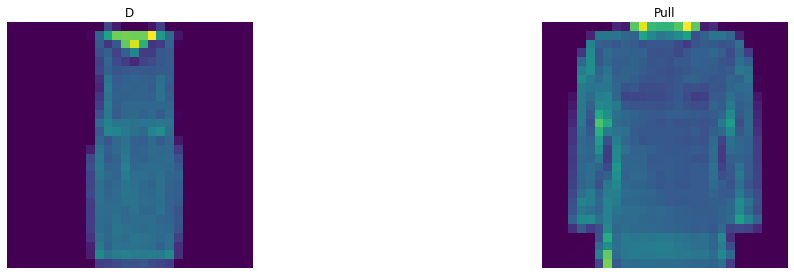

In [20]:
labels = np.unique(data['label'])           # Labels auslesen


# Matplot handling um Achsen zu erstellen
fig, axes = plt.subplots(1, len(labels))    # Plot definieren
fig.set_size_inches(15,4)                   # Größe
fig.tight_layout() 

# Generiert einen Plot mit einem Bild aus jeder Klasse
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)


## Datensatz umformen
Die derzeitige Form eines eingelesenen Bildes ist <index, breite, höhe, schichten> mit index für die Anzahl der Elemente, Breite/Höhe gibt die Bildgröße in Pixel an und Schichten beschreibt die Art des Bildes (3 = RGB)

Um eine Klassifikation durchzuführen benötigt das System einen Vektor mit maximal 2 Dimensionen. Wir wollen einen Vektor mit <index, pixel_vektor> wobei index gleich bleibt um mit den Labels übereinzustimmen. Der pixel_vektor wird aus den restlichen Ebenen gebildet, um einen 1*n Vektor zu erhalten.  



In [21]:
X = np.array(data['data'])                                      # Einlesen der Bilder
print("Original Form: {}".format(X.shape))                      
x = X.reshape(X.shape[0], X.shape[1]* X.shape[2])   # Umformen auf die beschriebene Größe
print("Umgeformter Datensatz der Form: {}".format(x.shape))

y = np.array(data['label'])                                     # Einlesen der Labels
print("Der Index muss mit der Labels größe Übereinstimmen. \nLabels größe: {}".format(y.shape)) #Abgleichen ob die Form übereinstimmt 

Original Form: (11976, 28, 28)
Umgeformter Datensatz der Form: (11976, 784)
Der Index muss mit der Labels größe Übereinstimmen. 
Labels größe: (11976,)


# Abschnitt 2: Erstellen des Modells

## Model

Im folgenden Abschnitt wird das Logistic Regression Model erstellt 
Hier wird der Abblauf wie folgt durchgeführt:
- (1)Datensatz aufteilen: Hier wird der Datensatz in einen Trainingsanteil und in einen Testanteil Aufgeteilt um zu überprüfen ob das Model in die richtige Richtung trainiert
- (2)Skalieren: Standardisierung von Merkmalen durch Entfernen des Mittelwerts und Skalierung auf Einheitsvarianz
- (3)PCA: Principal component analysis für eine lineare Dimensionalitätsreduktion des Eingangsvektors. ("Pixelreduktion" unserer Trainingsdaten)
- (4)Model definieren 
- (5)trainieren
- (6)Test Prediction
- (7)Auswertung 



Zum Einsatz kommt hier die sklearn Bibliothek welche ermöglicht ein bereits existierendes Model einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. 

Weitere [Dokumentation](https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

In [22]:


# Libraries
from cv2 import data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.datasets import load_svmlight_files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
import os
from sklearn.decomposition import PCA


########
# Data #

# (1)Aufteilen des Datensatzes
x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.15, random_state=0)

# (2) Skalieren
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# (3) PCA
pca = PCA(.95) # verwendet 95% der Komponenten
pca.fit(x_train)
pca.n_components_
print(pca.n_components_) #ausgabe der Komponenten an der Konsole
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

#######################
# (4) Model erstellen #
model = LogisticRegression(solver='saga', C=0.5, multi_class='ovr',random_state=0, max_iter=10000) 
    # solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    # C: Kehrwert der Regularisierungsstärke; optional; default = 1.0; kleiner Wert entspricht stärkkerer Regularisierung
    # random_state: (int) seed für das "zufällige" mischen der Daten
    # multi_class: "ovr" oder "multinomial"; ovr=binary Problem; multinomial=multinomial loss fit (funktioniert nur mit "lbfgs" solver)
    # 
    # more info: https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
    #

# (5) Trainieren des Models 
model.fit(x_train, y_train)

##############
# (6-7)Evaluation #
# get corresponding prediction 
y_pred = model.predict(x_test) # (6) Test Prediction
# (7)
#print("Model Parameter: {}\n".format(model.get_params(True)))
print("classes: {}".format(model.classes_))
print("Score training Data: {}".format(model.score(x_train, y_train)))
print("Score test Data: {}".format(model.score(x_test, y_test)))





180
classes: ['D' 'Pull']
Score training Data: 0.9812358777876019
Score test Data: 0.9760712298274903


### Auflistung der PCA Komponenten

In [23]:
print("Es werden {} PCA Punkte verwendet".format(pca.n_components_)) #anzahl an features

Es werden 180 PCA Punkte verwendet


## Demo Zelle für das Ausführen der Prediction für 2 Bilder
Die folgende Zelle nimmt nun das trainierte Modell her und führt eine Prediction anhand zwei demo Bilder durch. Diese sind in dem Demo Ordner hinterlegt. Ziel ist es einmal einen Workspace und einmal einen Hammer zu erkennen. Ist dies nicht der Fall, ist es wahrscheinlich keine gute Vorraussetzung für die Webcam-Implementation und die Modell-Parameter sollten überarbeitet werden. 

In [25]:

# Einlesen und definieren der Bilder
demo1 = "demo/001.png"
demo2 = "demo/002.png"
width = SIZE
height = SIZE

# Vorbereiten der Bilder
im1 = imread(demo1)
im1 = resize(im1, (width, height))
im1 = im1.reshape(1 ,-1)
im1 = scaler.transform(im1)
im1 = pca.transform(im1)

im2 = imread(demo2)
im2 = resize(im2, (width, height))
im2 = im2.reshape(1 ,-1)
im2 = scaler.transform(im2)
im2 = pca.transform(im2)


# Prediction und Ausgabe für das erste Bild
y_new_prob  = model.predict_proba(im1)
y_new  = model.predict(im1)
print("Hammer Example:")
print("Class: {}\t with Probability of: \t{} ".format(y_new[0], y_new_prob[0]))

# Prediction und Ausgabe für das zweite Bild
y_new_prob  = model.predict_proba(im2)
y_new  = model.predict(im2)
print("Workspace Example:")
print("Class: {}\t with Probability of: \t{} ".format(y_new[0], y_new_prob[0]))

(28, 28)
Hammer Example:
Class: D	 with Probability of: 	[0.99623029 0.00376971] 
Workspace Example:
Class: Pull	 with Probability of: 	[3.35831137e-05 9.99966417e-01] 


# Abschnitt 3: Webcam Implementierung

## Ausführung der Live erkennung
In der folgenden Zelle wird ein Kamerastream geöffnet und Frame für Frame eine Prediction durchgeführt. so wie es in dem Demo example auch passiert ist. Der unterschied hier ist lediglich, dass die Bilder nicht eingelesen werden über vorhandene Daten sondern dynamisch über die Kamera "generiert" werden.  


In [52]:

#libraries
from skimage.transform import resize
from sklearn.decomposition import PCA
import cv2
from IPython.display import clear_output


cv2.namedWindow('Prediction | press q to exit', 0)
i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename), 0)
    img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else: 
        # Bild aus einer Matrix in einen Vektor umformen 
        image = img.reshape(1 ,-1)

        # Bild an das Modell anpassen (Skalieren und PCA anwenden)
        image = scaler.transform(image)
        image = pca.transform(image)

        #Predict 
        y_new_prob  = model.predict_proba(image)
        y_new  = model.predict(image)

        # Wahrscheinlichkeit des Bildes (bei einer Klassifizierung) in Prozent umrechnen
        prob = y_new_prob[0]*100


        clear_output(wait=True)
        print("***************")
        i = i+1
        print("Example Image: {}".format(i))
        #Auswertung für die "live" Darstellung
        if (y_new == "D"):
            print("Dress")
            print("{:.2f}%".format(prob[0]))
        elif (y_new == "Pull"): 

            print("Pullover")
            print("{:.2f}%".format(prob[1]))
        else:
            print("Unknown Class: ({})".format(y_new))

        
        #Ausgabe 
        cv2.imshow('Prediction | press q to exit', img)
        #User Input für das beenden des Darstellen  
        if cv2.waitKey(1000) & 0xFF == ord('q'):    
            break


# Stream schließen und Window Handling

cv2.destroyAllWindows()

***************
Example Image: 18
Pullover
99.95%
